<a href="https://colab.research.google.com/github/abdelrhmanhesham1/projects/blob/main/diamonds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

         Unnamed: 0         carat         depth         table         price  \
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000   
mean   26970.500000      0.797940     61.749405     57.457184   3932.799722   
std    15571.281097      0.474011      1.432621      2.234491   3989.439738   
min        1.000000      0.200000     43.000000     43.000000    326.000000   
25%    13485.750000      0.400000     61.000000     56.000000    950.000000   
50%    26970.500000      0.700000     61.800000     57.000000   2401.000000   
75%    40455.250000      1.040000     62.500000     59.000000   5324.250000   
max    53940.000000      5.010000     79.000000     95.000000  18823.000000   

                  x             y             z  
count  53940.000000  53940.000000  53940.000000  
mean       5.731157      5.734526      3.538734  
std        1.121761      1.142135      0.705699  
min        0.000000      0.000000      0.000000  
25%        4.710000      4.720000     

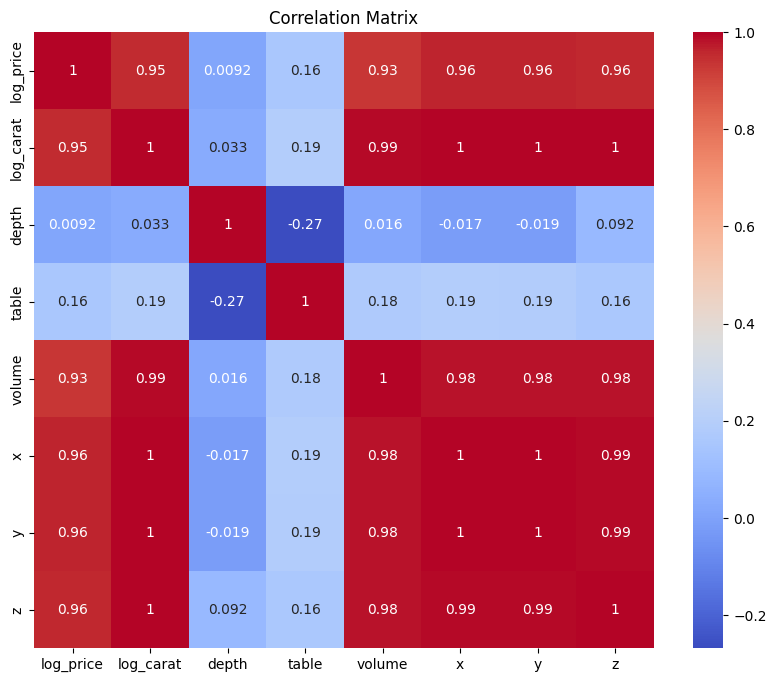


Tuned Random Forest Results:
RMSE (original scale): 512.07
R² (log scale): 0.9869

Tuned XGBoost Results:
RMSE (original scale): 437.02
R² (log scale): 0.9907

Cross-validation Results:
Tuned Random Forest CV R²: 0.7368 (+/- 0.5192)
Tuned XGBoost CV R²: 0.8248 (+/- 0.3645)


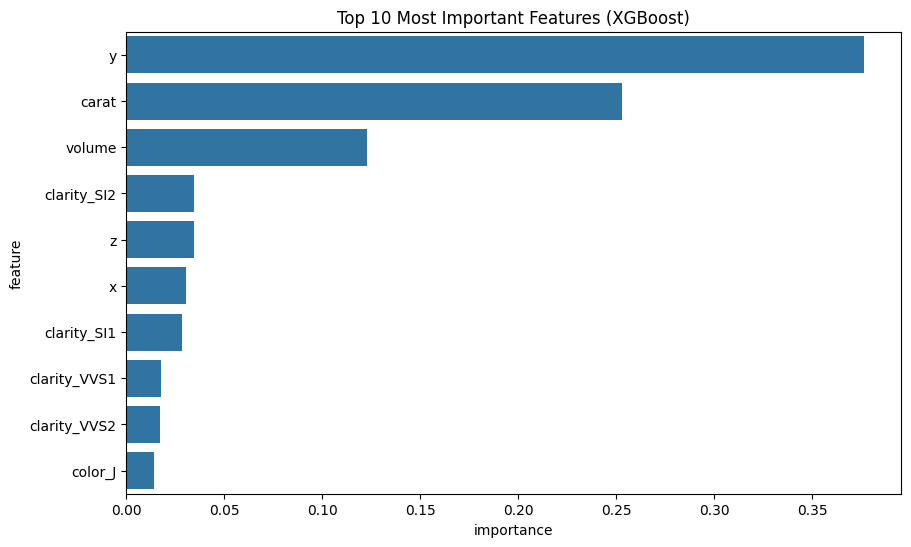

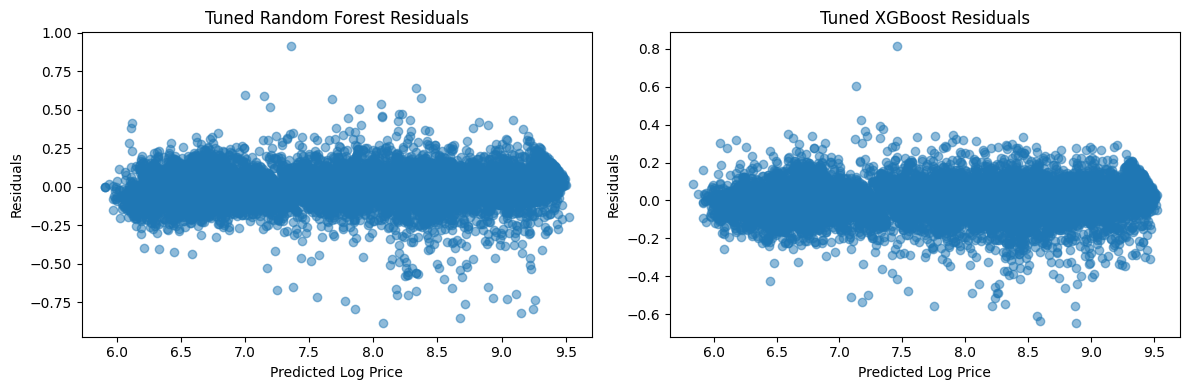

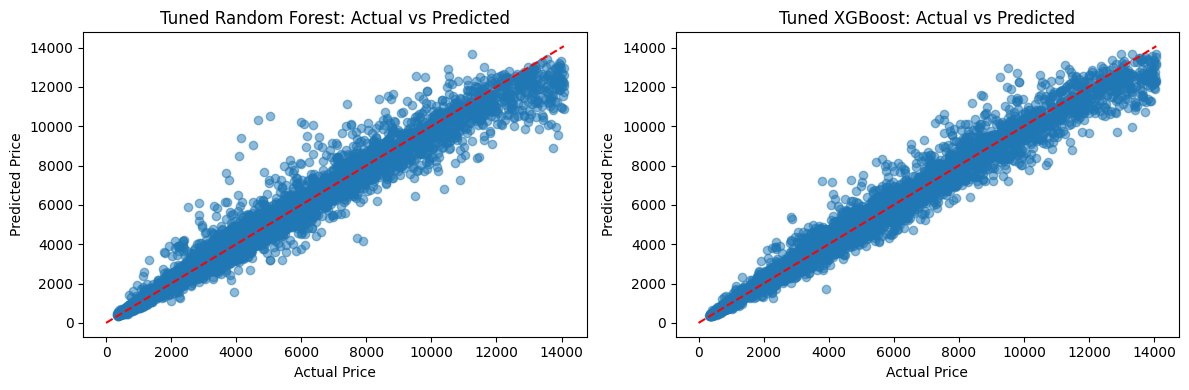

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import describe
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


# Load the dataset
df = pd.read_csv('/content/diamonds.csv')
print(df.describe())

# Drop the unnamed index column
df = df.drop(columns=['Unnamed: 0'])

# Feature Engineering
df['depth'] = (2 * df['z'] / (df['x'] + df['y'])) * 100
df['volume'] = df['x'] * df['y'] * df['z']
df['price'] = df['price'].fillna(df['price'].mean())
df['depth'] = df['depth'].fillna(df['depth'].mean())

# Log-transform skewed variables
df['log_price'] = np.log1p(df['price'])
df['log_carat'] = np.log1p(df['carat'])
df['log_volume'] = np.log1p(df['volume'])

# Remove outliers using IQR method
def remove_outliers(df, column, factor=2.0):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in ['price', 'carat', 'volume', 'depth', 'table', 'x', 'y', 'z']:
    df = remove_outliers(df, col)

# Convert categorical variables to dummy variables
df = pd.get_dummies(df, columns=['cut', 'color', 'clarity'], drop_first=True)

# EDA
print("Cleaned Dataset Summary:")
print(df.describe())

# Correlation matrix
numerical_df = df[['log_price', 'log_carat', 'depth', 'table', 'volume', 'x', 'y', 'z']]
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Prepare data for modeling
X = df.drop(['price', 'log_price'], axis=1)
y = df['log_price']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Random Forest with Hyperparameter Tuning
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}
rf = RandomForestRegressor(random_state=42)
rf_search = RandomizedSearchCV(rf, rf_param_grid, n_iter=10, cv=5, scoring='r2', random_state=42, n_jobs=-1)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
rf_pred = best_rf.predict(X_test)

# XGBoost with Hyperparameter Tuning
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb = XGBRegressor(random_state=42)
xgb_search = RandomizedSearchCV(xgb, xgb_param_grid, n_iter=10, cv=5, scoring='r2', random_state=42, n_jobs=-1)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
xgb_pred = best_xgb.predict(X_test)

# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    y_true_orig = np.expm1(y_true)  # Convert back from log scale
    y_pred_orig = np.expm1(y_pred)
    rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    r2 = r2_score(y_true, y_pred)  # R² on log scale for consistency
    print(f"\n{model_name} Results:")
    print(f"RMSE (original scale): {rmse:.2f}")
    print(f"R² (log scale): {r2:.4f}")
    return rmse, r2

rf_rmse, rf_r2 = evaluate_model(y_test, rf_pred, "Tuned Random Forest")
xgb_rmse, xgb_r2 = evaluate_model(y_test, xgb_pred, "Tuned XGBoost")

# Cross-validation
rf_cv_scores = cross_val_score(best_rf, X_scaled, y, cv=5, scoring='r2')
xgb_cv_scores = cross_val_score(best_xgb, X_scaled, y, cv=5, scoring='r2')

print("\nCross-validation Results:")
print(f"Tuned Random Forest CV R²: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std() * 2:.4f})")
print(f"Tuned XGBoost CV R²: {xgb_cv_scores.mean():.4f} (+/- {xgb_cv_scores.std() * 2:.4f})")

# Feature Importance (XGBoost)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_xgb.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title("Top 10 Most Important Features (XGBoost)")
plt.show()

# Residual Plots
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(rf_pred, y_test - rf_pred, alpha=0.5)
plt.xlabel("Predicted Log Price")
plt.ylabel("Residuals")
plt.title("Tuned Random Forest Residuals")

plt.subplot(1, 2, 2)
plt.scatter(xgb_pred, y_test - xgb_pred, alpha=0.5)
plt.xlabel("Predicted Log Price")
plt.ylabel("Residuals")
plt.title("Tuned XGBoost Residuals")
plt.tight_layout()
plt.show()

# Scatter plot of actual vs predicted
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(np.expm1(y_test), np.expm1(rf_pred), alpha=0.5)
plt.plot([0, max(np.expm1(y_test))], [0, max(np.expm1(y_test))], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Tuned Random Forest: Actual vs Predicted")

plt.subplot(1, 2, 2)
plt.scatter(np.expm1(y_test), np.expm1(xgb_pred), alpha=0.5)
plt.plot([0, max(np.expm1(y_test))], [0, max(np.expm1(y_test))], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Tuned XGBoost: Actual vs Predicted")
plt.tight_layout()
plt.show()